In [9]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.7.1
Torchvision Version:  0.8.2


In [10]:
data_dir = "data/aug_dataset/"
model_name = "alexnet"

num_classes = 6

batch_size = 128

num_epochs = 100
feature_extract = True

In [11]:
Tr_Loss = []
Tr_Accuracy = []
Val_Loss = []
Val_Accuracy = []

def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    for epoch in range(num_epochs):
        #scheduler.step()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        _, preds = torch.max(outputs, 1)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            if phase == 'train':
                Tr_Loss.append(epoch_loss)
                Tr_Accuracy.append(epoch_acc)
            else:
                Val_Loss.append(epoch_loss)
                Val_Accuracy.append(epoch_acc)
                
            print('{} Loss: {:.4f} Acc: {:.4f} Lr: {}'.format(phase, epoch_loss, epoch_acc, optimizer.param_groups[0]['lr']))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

In [12]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [13]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet152(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 150
        
    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 150
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

print(model_ft)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [14]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'validation']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'validation']}

image_datasets

Initializing Datasets and Dataloaders...


{'train': Dataset ImageFolder
     Number of datapoints: 28068
     Root location: data/aug_dataset/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(150, 150), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'validation': Dataset ImageFolder
     Number of datapoints: 3000
     Root location: data/aug_dataset/validation
     StandardTransform
 Transform: Compose(
                Resize(size=150, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(150, 150))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [16]:
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.0001, momentum=0.7)
#scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [17]:
criterion = nn.CrossEntropyLoss()

model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/99
----------
train Loss: 0.9452 Acc: 0.6898 Lr: 0.0001
validation Loss: 0.5571 Acc: 0.7880 Lr: 0.0001

Epoch 1/99
----------
train Loss: 0.5943 Acc: 0.8002 Lr: 0.0001
validation Loss: 0.4985 Acc: 0.8027 Lr: 0.0001

Epoch 2/99
----------
train Loss: 0.5333 Acc: 0.8153 Lr: 0.0001
validation Loss: 0.4657 Acc: 0.8140 Lr: 0.0001

Epoch 3/99
----------
train Loss: 0.5037 Acc: 0.8219 Lr: 0.0001
validation Loss: 0.4561 Acc: 0.8170 Lr: 0.0001

Epoch 4/99
----------
train Loss: 0.4883 Acc: 0.8273 Lr: 0.0001
validation Loss: 0.4444 Acc: 0.8217 Lr: 0.0001

Epoch 5/99
----------
train Loss: 0.4678 Acc: 0.8323 Lr: 0.0001
validation Loss: 0.4366 Acc: 0.8260 Lr: 0.0001

Epoch 6/99
----------
train Loss: 0.4571 Acc: 0.8333 Lr: 0.0001
validation Loss: 0.4213 Acc: 0.8360 Lr: 0.0001

Epoch 7/99
----------
train Loss: 0.4475 Acc: 0.8394 Lr: 0.0001
validation Loss: 0.4175 Acc: 0.8360 Lr: 0.0001

Epoch 8/99
----------
train Loss: 0.4420 Acc: 0.8393 Lr: 0.0001
validation Loss: 0.4084 Acc: 0.8393 Lr: 

train Loss: 0.3542 Acc: 0.8712 Lr: 0.0001
validation Loss: 0.3407 Acc: 0.8690 Lr: 0.0001

Epoch 74/99
----------
train Loss: 0.3484 Acc: 0.8731 Lr: 0.0001
validation Loss: 0.3350 Acc: 0.8737 Lr: 0.0001

Epoch 75/99
----------
train Loss: 0.3527 Acc: 0.8689 Lr: 0.0001
validation Loss: 0.3364 Acc: 0.8727 Lr: 0.0001

Epoch 76/99
----------
train Loss: 0.3495 Acc: 0.8709 Lr: 0.0001
validation Loss: 0.3403 Acc: 0.8693 Lr: 0.0001

Epoch 77/99
----------
train Loss: 0.3470 Acc: 0.8727 Lr: 0.0001
validation Loss: 0.3404 Acc: 0.8680 Lr: 0.0001

Epoch 78/99
----------
train Loss: 0.3543 Acc: 0.8697 Lr: 0.0001
validation Loss: 0.3379 Acc: 0.8717 Lr: 0.0001

Epoch 79/99
----------
train Loss: 0.3519 Acc: 0.8690 Lr: 0.0001
validation Loss: 0.3374 Acc: 0.8727 Lr: 0.0001

Epoch 80/99
----------
train Loss: 0.3519 Acc: 0.8717 Lr: 0.0001
validation Loss: 0.3393 Acc: 0.8707 Lr: 0.0001

Epoch 81/99
----------
train Loss: 0.3498 Acc: 0.8703 Lr: 0.0001
validation Loss: 0.3394 Acc: 0.8693 Lr: 0.0001

Epoch 

TypeError: cannot unpack non-iterable NoneType object

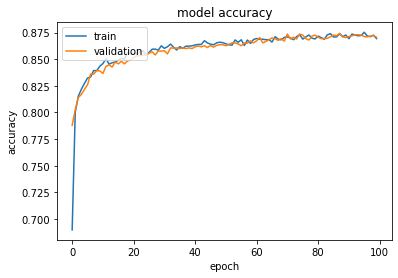

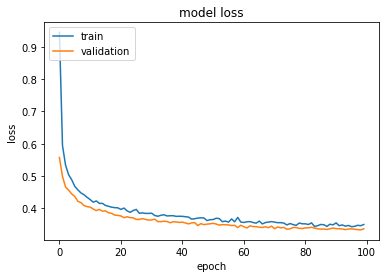

In [18]:
#Accuracy
plt.plot(Tr_Accuracy)
plt.plot(Val_Accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(Tr_Loss)
plt.plot(Val_Loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [19]:
Path = "Alexnet_AugData_ConstantLearningRate.pth"
torch.save(model_ft.state_dict(), Path)

In [20]:
model = model_ft.load_state_dict(torch.load("Alexnet_AugData_ConstantLearningRate.pth"))
model = model_ft.eval().to(device)

In [21]:
transform = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [22]:
def get_predictions(model, Loader):
    A_Preds = torch.tensor([]).to(device = device)
    
    for batch in Loader:
        images, labels = batch

        images = images.to(device = device)
        labels = labels.to(device = device)
     
        pred = model(images)
        A_Preds = torch.cat((A_Preds, pred), dim = 0)
        
        return A_Preds

In [23]:
Test_Dataset = datasets.ImageFolder('data/aug_dataset/test/', transform)

In [24]:
Pred_Loader = torch.utils.data.DataLoader(Test_Dataset, batch_size = 10, shuffle=True)

In [25]:
def get_num_correct (preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [34]:
classes = 'buildings','forest','glacier','mountains','sea','street'

In [27]:
from sklearn.metrics import confusion_matrix

predlist=torch.zeros(0,dtype=torch.long).to(device)
lbllist=torch.zeros(0,dtype=torch.long).to(device)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(Pred_Loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs).to(device)
        _, preds = torch.max(outputs, 1)

        predlist=torch.cat([predlist,preds.view(-1)])
        lbllist=torch.cat([lbllist,classes.view(-1)])

conf_mat = confusion_matrix(lbllist.cpu().data.numpy(), predlist.cpu().data.numpy())

class_accuracy = 100 * conf_mat.diagonal() / conf_mat.sum(1)

print(conf_mat)

[[ 925    4   10    6   15  184]
 [   8 1121    3   12    4   18]
 [  10    6  898  306  105    5]
 [   7   16  119 1022  126    7]
 [  16    7   43   78  968   16]
 [ 107   16    8   11   20 1074]]


In [31]:
from PIL import Image

filename = ("data/aug_dataset/test/mountain/28.jpg")
#filename = ("C:/Users/Muhammad Atif Butt/Desktop/4.jpg")
input_image = Image.open(filename)

In [32]:
preprocess = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

input_tensor = preprocess(input_image).to(device)
input_batch = input_tensor.unsqueeze(0)
input_batch.shape

torch.Size([1, 3, 150, 150])

tensor([1.0632e-04, 1.0224e-04, 2.3442e-03, 9.9714e-01, 2.5388e-04, 5.5825e-05],
       device='cuda:0')
tensor(3, device='cuda:0')
mountains


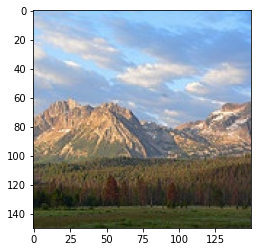

In [35]:
with torch.no_grad():
    output = model(input_batch)

per = torch.nn.functional.softmax(output[0], dim=0)
index = torch.argmax(per, dim = 0)

plt.imshow(input_image)
print(per)
print(index)
print(classes[index])